In [1]:
from PIL import Image, ImageDraw

In [2]:
class GeneSigil:
    base_start_x = 10
    base_start_y = 20
    base_length = 40
    arrow_height = -15
    arrow_length = 10
    arrowpoint_width = 4
    arrowpoint_height = 3

    def __init__(self, color, name, *, start_x=0, start_y=0):
        self.color = color
        self.name = name
        self.start_x = start_x
        self.start_y = start_y

        self.into = {}
        self.into_n = 0

    def draw(self, canvas):
        imdraw = canvas

        # draw promoter/gene body
        start_x = self.start_x
        start_y = self.start_y
        base_start_x = self.base_start_x
        base_start_y = self.base_start_y
        base_length = self.base_length
        arrow_height = self.arrow_height
        arrow_length = self.arrow_length

        line_coords = [ (x + self.start_x, y + self.start_y) for (x, y) in
                          ((base_start_x, base_start_y),
                           (base_start_x + base_length, base_start_y),
                           (base_start_x + base_length, base_start_y + arrow_height),
                           (base_start_x + base_length + arrow_length, base_start_y + arrow_height)) ]
        imdraw.line(line_coords, fill=self.color, width=2, joint='curve')

        # draw arrowpoint
        arrowpoint_x = base_start_x + base_length + arrow_length
        arrowpoint_y = base_start_y + arrow_height
        arrowpoint_width = self.arrowpoint_width
        arrowpoint_height = self.arrowpoint_height
        poly_coords = [ (x + self.start_x, y + self.start_y) for (x, y) in
                           ((arrowpoint_x, arrowpoint_y),
                            (arrowpoint_x - arrowpoint_width, arrowpoint_y - arrowpoint_height + 1),
                            (arrowpoint_x - arrowpoint_width, arrowpoint_y + arrowpoint_height),
                            (arrowpoint_x, arrowpoint_y))]
        imdraw.polygon(poly_coords, fill=self.color)

        imdraw.text((30 + self.start_x, 30 + self.start_y), self.name, fill=self.color, anchor='mm')

    def estimate_size(self):
        return (70, 42)

    def get_cisreg_point(self, connection_name):
        "Return a two-point line element going from cisreg region to top of gene cell"
        n = self.into.get(connection_name)
        if n is None:
            n = self.into_n
            self.into_n += 1
            self.into[connection_name] = n

        assert n < 10

        point_f = (n + 1) / 12
        point_x = self.base_start_x + self.base_length*point_f

        start_y = self.start_y + self.base_start_y
        end_y = 0

        return [(point_x, start_y), (point_x, end_y)]

    def get_gene_out_point(self):
        "Return a two-point line element going from tip of gene out to right side of gene cell"
        start_x = self.start_x
        start_y = self.start_y
        base_start_x = self.base_start_x
        base_start_y = self.base_start_y
        base_length = self.base_length
        arrow_height = self.arrow_height
        arrow_length = self.arrow_length
        
        arrowpoint_x = start_x + base_start_x + base_length + arrow_length
        arrowpoint_y = start_y + base_start_y + arrow_height

        right_side = self.estimate_size()[0]

        return ((arrowpoint_x, arrowpoint_y), (start_x + right_side, arrowpoint_y))


size: (70, 42)
((60, 5), (70, 5))


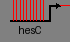

In [3]:
gene = GeneSigil('black', 'hesC')
size = gene.estimate_size()
print(f'size: {size}')

im = Image.new('RGB', size, 'grey')
imdraw = ImageDraw.Draw(im)
gene.draw(imdraw)

for i in range(10):
    line_coords = gene.get_cisreg_point(i)
    imdraw.line(line_coords, fill="red")

gene_out_line = gene.get_gene_out_point()
imdraw.line(gene_out_line, fill='red')
print(gene_out_line)

im

In [12]:
class TissueSigil:
    def __init__(self, n_rows, n_cols):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.gene_sigils = {}
        self.gene_sigils_row_col = {}
        self.paths = []

        g = GeneSigil('black', 'ubiq')
        gene_size = g.estimate_size()
        self.padding = (int(0.25 * gene_size[0]), int(0.25 * gene_size[0]))
        self.box_size = (1.5 * gene_size[0], 1.5*gene_size[1])

    def estimate_size(self):
        width = int(self.n_rows * self.box_size[0])
        height = int(self.n_rows * self.box_size[1])
        return (width, height)

    def build(self):
        box_size = self.box_size
        padding = self.padding
        gs = self.gene_sigils
        gs_rowcol = self.gene_sigils_row_col

        for row in range(self.n_rows):
            for col in range(self.n_cols):
                name = f"{row}.{col}"
                assert name not in gs
                
                color = 'black'
                g = GeneSigil(color, name, start_x=col*box_size[0]+padding[0], start_y = row*box_size[1] + padding[1])

                gs[g.name] = g
                gs_rowcol[g.name] = (row, col)

    def add_path(self, from_g, to_g):
        assert from_g in self.gene_sigils
        assert to_g in self.gene_sigils

        self.paths.append((from_g, to_g))
                
    def draw(self, canvas):
        for g in self.gene_sigils.values():
            g.draw(canvas)

        for (from_g, to_g) in self.paths:
            self._draw_path(canvas, from_g, to_g)

    def _draw_path(self, canvas, from_g, to_g):
        # get row, col
        from_row, from_col = self.gene_sigils_row_col[from_g]
        to_row, to_col = self.gene_sigils_row_col[to_g]

        # gene out coordinates
        from_g = self.gene_sigils[from_g]
        to_g = self.gene_sigils[to_g]
        
        cisreg_point = to_g.get_cisreg_point(from_g)
        geneout_point = from_g.get_gene_out_point()

        ### 
        print(cisreg_point, geneout_point)

        box_size_x, box_size_y = self.box_size
        padding = self.padding

        from_x = box_size_x * (from_col + 1)
        from_y = box_size_y * (from_row + 1)

        to_x = box_size_x * (to_col + 1)
        to_y = box_size_y * (to_row + 1)

        canvas.line([(from_x, from_y), (to_x, to_y)], fill='blue')
        

size: (525, 315)
[(13.333333333333332, 37.0), (13.333333333333332, 0)] ((77.0, 22.0), (87.0, 22.0))
[(13.333333333333332, 100.0), (13.333333333333332, 0)] ((77.0, 22.0), (87.0, 22.0))


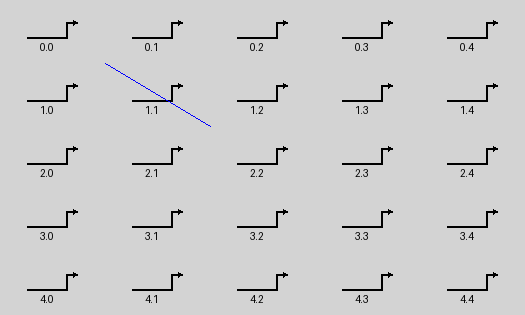

In [13]:
tissue = TissueSigil(5, 5)
tissue.build()
tissue.add_path("0.0", "0.0")
tissue.add_path("0.0", "1.1")
size = tissue.estimate_size()
print(f'size: {size}')

im = Image.new('RGB', size, 'lightgrey')
imdraw = ImageDraw.Draw(im)
tissue.draw(imdraw)
im